In [ ]:
#Notes from chapter 17: Linear Classifiers
# linear classifier: single number resulting from a regression type equation
# if the result > 0, class A, if result < 0, class B

#LDA: not great

#QDA: better than LDA
# lets you have a more complex model -- could be better, or could overfit

# Support Vector Classifiers (SVC)
# Margines should be big, but not too big that many observations fall into uncertainty zone
#   need a Loss Function --> determines how far the boundaries can be pushed out
#     Tune the loss function of SVC (parameter C)
#     Can also alter the kernel, or number of dimensions


In [22]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [82]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

#sex, cp, restecg, output will need to be dummified

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [24]:
X1 = ha[["age", "chol"]]
y1 = ha["output"]
X_train, X_test, y_train, y_test = train_test_split(X1, y1)

In [40]:
#logistic regression

logr_pipeline = Pipeline(
  [("logr",  LogisticRegression())]
).set_output(transform = "pandas")

In [41]:
lr_fit = logr_pipeline.fit(X_train, y_train)
lr_mse = cross_val_score(logr_pipeline, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error").mean() * -1
lr_mse

0.3384146341463415

In [42]:
lr_fit.named_steps['logr'].coef_

array([[-0.06262475, -0.0033185 ]])

In [43]:
intercept = lr_fit.named_steps['logr'].intercept_[0]
coef_age = lr_fit.named_steps['logr'].coef_[0][0]
coef_chol = lr_fit.named_steps['logr'].coef_[0][1]
print(intercept)
print(coef_age)
print(coef_chol)

4.321681079470728
-0.06262474771217133
-0.00331849753844731


In [44]:
chol_for_05_prob = (0 - intercept - coef_age * 55) / coef_chol

chol_for_09_prob = (np.log(9) - intercept - coef_age * 55) / coef_chol


print(f"For a 55 year old, cholesterol needs to be above {chol_for_05_prob:.2f} for doctors to predict heart disease.")
print(f"For a 55 year old, cholesterol needs to be above {chol_for_09_prob:.2f} for a 90% chance of heart disease.")

For a 55 year old, cholesterol needs to be above 264.37 for doctors to predict heart disease.
For a 55 year old, cholesterol needs to be above -397.74 for a 90% chance of heart disease.


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [45]:
lda_pipeline = Pipeline(
  [("lda",  LinearDiscriminantAnalysis())]
).set_output(transform = "pandas")

In [46]:
lda_fit = lda_pipeline.fit(X_train, y_train)
lda_fit.named_steps['lda'].coef_

array([[-0.06254599, -0.00327171]])

In [47]:
intercept2 = lda_fit.named_steps['lda'].intercept_[0]
coef_age2 = lda_fit.named_steps['lda'].coef_[0][0]
coef_chol2 = lda_fit.named_steps['lda'].coef_[0][1]
print(intercept2)
print(coef_age2)
print(coef_chol2)

4.3025456809182625
-0.06254599224074295
-0.0032717113390408137


In [48]:
age = 55
# For LDA, we want to find the cholesterol level where the linear discriminant function is 0
chol_lda = (-intercept2 - coef_age2 * age) / coef_chol2


print(f"For a 55-year-old, using LDA, a cholesterol level of approximately {chol_lda:.2f} would predict heart disease is present.")


For a 55-year-old, using LDA, a cholesterol level of approximately 263.63 would predict heart disease is present.


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [49]:
from sklearn.svm import SVC

svc_pipeline = Pipeline(
  [("svc",  SVC(kernel = 'linear'))]
).set_output(transform = "pandas")

In [50]:
svc_fit = svc_pipeline.fit(X_train, y_train)
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 15, 20, 30, 50, 100],
    'svc__kernel': ['linear']
}
grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring = "accuracy")
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'svc__C': 0.1, 'svc__kernel': 'linear'}

In [51]:
svc_pipeline.set_params(svc__C = 10)
svc_fitf = svc_pipeline.fit(X1, y1)


In [52]:
svc_coefs = svc_fitf.named_steps['svc'].coef_
svc_intercept = svc_fitf.named_steps['svc'].intercept_
chol55 = (np.log(.9/.1) + -svc_intercept[0] - 55*svc_coefs[0][0]) / svc_coefs[0][1]
chol55

-909.8278813243645

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [66]:

df_log = pd.DataFrame({
    "x": list(range(40, 70)),
    "y": list(map(lambda x: (-coef_age / coef_chol) * x - intercept / coef_chol, range(40, 70)))
})
df_logistic['x'] = df_logistic["x"].astype(float)
df_logistic['y'] = df_logistic["y"].astype(float)



In [65]:
df_lda = pd.DataFrame({
    "x": list(range(40, 70)),
    "y": list(map(lambda x: (-coef_age2 / coef_chol2) * x - intercept2 / coef_chol2, range(40, 70)))
})
df_lda['x'] = df_lda["x"].astype(float)
df_lda['y'] = df_lda["y"].astype(float)

In [64]:
df_svc = pd.DataFrame({
    "x": list(range(40, 70)),
    "y": list(map(lambda x: (-svc_coefs[0][0] / svc_coefs[0][1]) * x - svc_intercept[0] / svc_coefs[0][1], range(40, 70)))
})
df_svc['x'] = df_svc["x"].astype(float)
df_svc['y'] = df_svc["y"].astype(float)

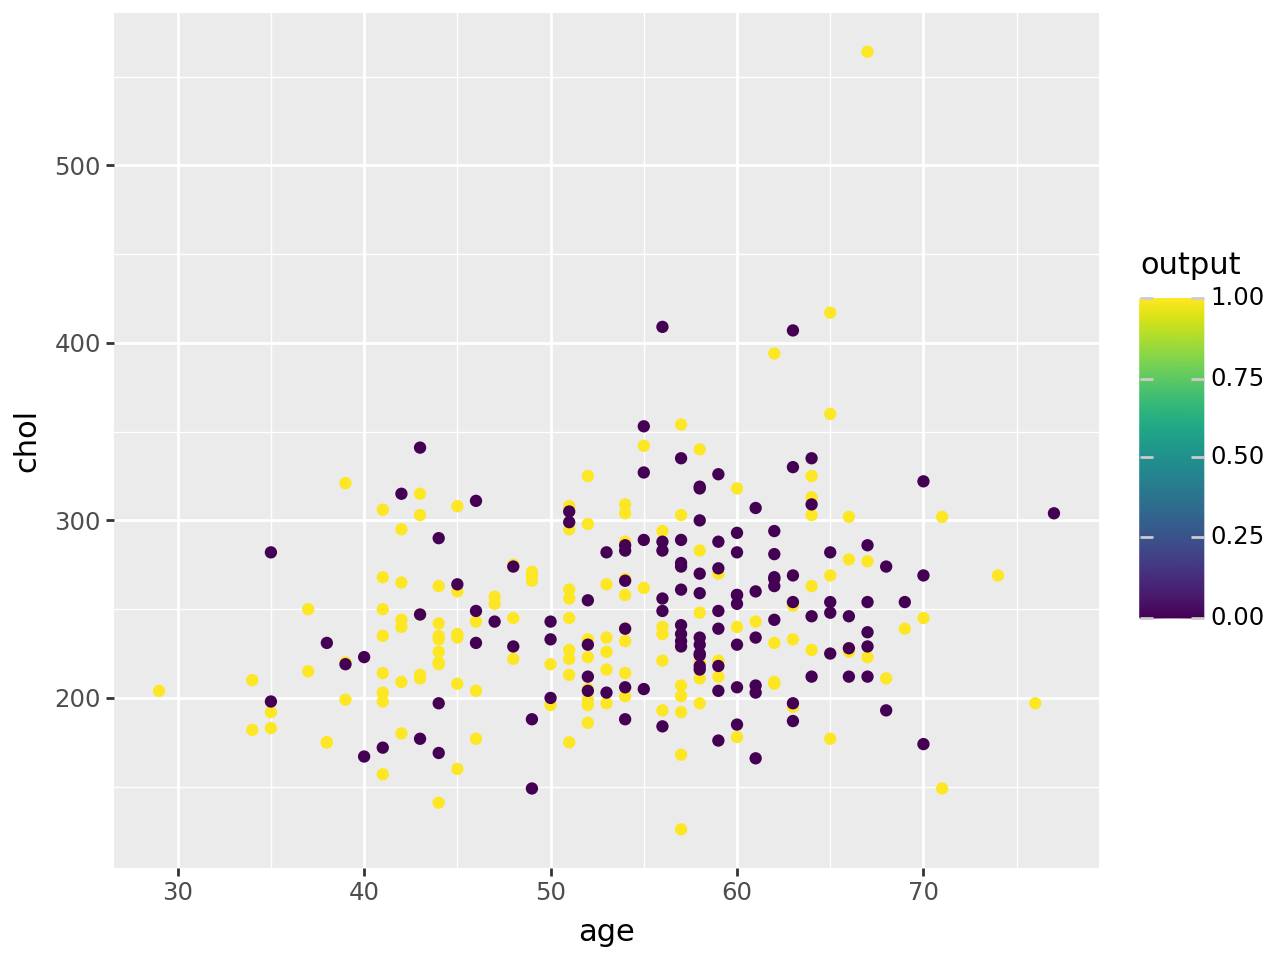

In [84]:
from plotnine import *
(ggplot(data=ha, mapping=aes(x="age", y="chol", color="output"))
    + geom_point()
)

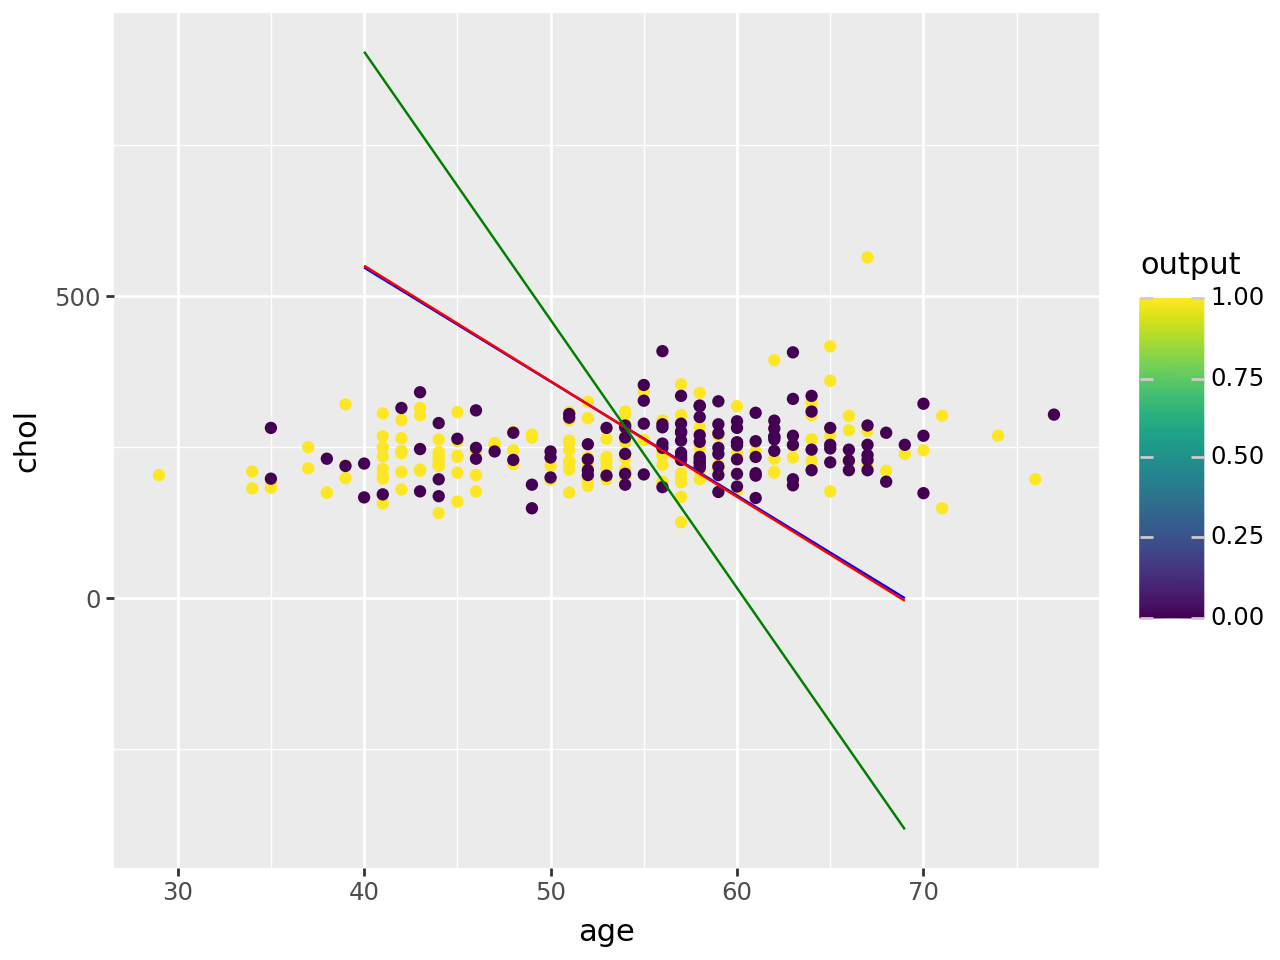

In [97]:
(
    ggplot(data=ha, mapping=aes(x='age', y='chol', color='output')) +
    geom_point() +
    geom_line(data=df_log, mapping=aes(x='x', y='y'), color='blue', inherit_aes=False) +
    geom_line(data=df_lda, mapping=aes(x='x', y='y'), color='red', inherit_aes=False) +
    geom_line(data=df_svc, mapping=aes(x='x', y='y'), color='green', inherit_aes=False) +
    labs(
        x="age",
        y="chol",
    )
)
